In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas import ExcelWriter
from pandas import ExcelFile
from bisect import bisect
import operator

import os
from os import listdir

from os.path import isfile, join


In [2]:
def read_combined_data(filename,airbag_data):
    data = pd.read_excel (combined_path+filename)
    data = data[(data['eventLabel']>100) & (data['eventLabel'] < 200) &
                (data['impactTime_ms'].notnull()) & ((data['eventStart_ms']) < (airbag_data.iloc[-1][0]))]
    data = data[['eventLabel','eventStart_ms','impactTime_ms', 'eventEnd_ms','eventDuration_ms']]
    data.columns = ['eventLabel','Start milisec','Impact milisec', 'End Milisec','eventDuration_ms']
    return data

In [3]:
# Adding the fall value by choosing the maximum magitude in the fall range from combined data
def add_new_fall_value(airbag_data,manual_data):
    airbag_data['accel_base_mag'] =  np.sqrt(airbag_data['accel_base_X']**2 + airbag_data['accel_base_Y']**2 + 
                                             airbag_data['accel_base_Z']**2)
    print("shape of falls combined ",manual_data.shape)
    for index, row in manual_data.iterrows():
        airbag_data.loc[(airbag_data['time_counter'] >= row['Start milisec']) &
                        (airbag_data['time_counter'] < row['End Milisec']),'fall_check'] = 88
        airbag_data.loc[(airbag_data['accel_base_mag'] == \
                                                  (airbag_data.loc[(airbag_data['time_counter'] >= row['Start milisec']) & \
                                                                   (airbag_data['time_counter'] < row['End Milisec']),
                                                                   'accel_base_mag'].max())) & \
                                                 (airbag_data['time_counter'] >= row['Start milisec']) & \
                                                 (airbag_data['time_counter'] < row['End Milisec']),
                                                 'cal_impact_milisec'] = 80
        if(any(airbag_data['time_counter'] == row['Impact milisec'])):
            airbag_data.loc[(airbag_data['time_counter'] == row['Impact milisec']),'impact_value'] =  84
        else:
            airbag_data.loc[bisect(airbag_data['time_counter'].values, row['Impact milisec']),'impact_value'] =  84

In [4]:
def big_size_plot_of_acceleration_vs_time(data, name, x=15, y=10, left = -1, right = -1):
    fig, axs = plt.subplots(figsize=(x,y))
    fig.suptitle('Bace acceleration for AIRBAG-'+name)
    
    axs.plot( data.time_counter*(10**(-3)),data.accel_base_X, marker='', color='red', linewidth=1, label='X')
    axs.plot( data.time_counter*(10**(-3)),data.accel_base_Y, marker='', color='blue', linewidth=1, label='Y')
    axs.plot( data.time_counter*(10**(-3)),data.accel_base_Z, marker='', color='green', linewidth=1, label='Z')
    axs.plot( data.time_counter*(10**(-3)),data.accel_base_mag, marker='', color='black', linewidth=1, label='Magnitude')
    axs.scatter(data.time_counter*(10**(-3)),data.cal_impact_milisec/4,s=30,c = 'violet')
    
    if (left>-1 and right>-1):
        axs.set_xlim(left,right)
    elif (left > -1):
        axs.set_xlim(left)
    elif (right > -1):
        axs.set_xlim(right)
    else:
        axs.set_xlim()
    
    axs.legend()
    axs.set_title('Data')

In [5]:
def acceleration_vs_time(data,label):
    fig, axs = plt.subplots(2, 2,figsize=(15,10))
    fig.suptitle('Bace acceleration for AIRBAG-'+label)

    axs[0, 0].plot(data.time_counter*(10**(-3))/60,data.accel_base_X*(10**(-3)), marker='', color='red', linewidth=1)
    axs[0, 0].scatter(data.time_counter*(10**(-3))/60,data.fall_detection/4,s=5,c = 'brown')
    axs[0, 0].set_title('acceleration X')
    
    axs[0, 1].plot(data.time_counter*(10**(-3))/60,data.accel_base_Y*(10**(-3)), marker='', color='blue', linewidth=1)
    axs[0, 1].scatter(data.time_counter*(10**(-3))/60,data.fall_detection/4,s=5,c = 'brown')
    axs[0, 1].set_title('acceleration Y')
    
    axs[1, 0].plot(data.time_counter*(10**(-3))/60,data.accel_base_Z*(10**(-3)), marker='', color='green', linewidth=1)
    axs[1, 0].scatter(data.time_counter*(10**(-3))/60,data.fall_detection/4,s=5,c = 'brown')
    axs[1, 0].set_title('acceleration Z')
    
    axs[1, 1].plot( data.time_counter*(10**(-3))/60,data.accel_base_X*(10**(-3)), marker='', color='red', linewidth=1)
    axs[1, 1].plot( data.time_counter*(10**(-3))/60,data.accel_base_Y*(10**(-3)), marker='', color='blue', linewidth=1)
    axs[1, 1].plot( data.time_counter*(10**(-3))/60,data.accel_base_Z*(10**(-3)), marker='', color='green', linewidth=1)
    axs[1, 1].scatter(data.time_counter*(10**(-3))/60,data.fall_detection/4,s=5,c = 'brown')
    axs[1, 1].set_title('acceleration all axis')

In [6]:
def plot_falls_zoomed(subject, left, right, name, fn, width=10, height=8):
    fig, axs = plt.subplots(figsize=(width, height))
    falls = subject.loc[subject["cal_impact_milisec"] == 80]
    fall_times = falls['time_counter'].values.tolist()
    
    fig.suptitle("Subject " + name + " - Fall Number " + str(fn+1) + " - Occurs at " + str(fall_times[fn] * (10 ** (-3))) + " s")
    fc = 1
    
    # Get Indexes for time
    start_time = fall_times[fn] - left
    end_time = fall_times[fn] + right
    start_time = subject.loc[subject["time_counter"] == start_time].index[0]
    end_time = subject.loc[subject["time_counter"] == end_time].index[0]

    # Setup X and Y for plotting
    time = subject.loc[start_time:end_time, 'time_counter'] * (10**(-3))
    accel = subject.loc[start_time:end_time, 'accel_base_mag'] *(10**(-3))
    x = subject.loc[start_time:end_time, 'accel_base_X'] * (10**(-3))
    y = subject.loc[start_time:end_time, 'accel_base_Y'] * (10**(-3))
    z = subject.loc[start_time:end_time, 'accel_base_Z'] *(10**(-3))
#     fall = subject.loc[start_time:end_time, 'cal_impact_milisec'] *(10**(-3))
# 
    # Plot Graphs
    plt.xlabel("Time in (s)")
    plt.ylabel("XYZ, Magnitude")
    axs.plot(time, accel, marker='', color='black', linewidth=1, alpha = 0.8, label="Accel")
    axs.plot(time, x, marker='', color='blue', linewidth=1, alpha = 0.8, label="X")
    axs.plot(time, y, marker='', color='green', linewidth=1, alpha = 0.8, label="Y")
    axs.plot(time, z, marker='', color='red', linewidth=1, alpha = 0.8, label="Z")
    
    # Plot Max Fall Time
    plt.axvline(x = fall_times[fn] * (10**(-3)), color="m", linewidth=1, label="Impact")
    
    
    # Plot One Second Rem Range
    plt.axvline(x = fall_times[fn] * (10**(-3)) + 1, color="m", linewidth=3, label="Fall Radius")
    plt.axvline(x = fall_times[fn] * (10**(-3)) - 1, color="m", linewidth=3)

    ul = max(max(accel), max(x), max(y), max(z)) + 5
    dl = min(min(accel), min(x), min(y), min(z)) - 5
     
    plt.ylim(dl, ul)
    plt.legend()
    return fig

## Reading all files and printing their shape

In [260]:
def generate_all_falls(subject):
    data_path = "../../../Airbag_Data/Strokes_data/"+subject+"_Raw Data/Airbag/"
    combined_path = "../../../Airbag_Data/Strokes_data/combined excel files/"
    files = [f for f in listdir(data_path) if isfile(join(data_path, f)) and '.CSV' in f]
    files.sort()
    print("Files present in ",subject," folder")
    for file in files:
        df = pd.read_csv(data_path+file,names = ['time_counter','accel_base_X','accel_base_Y','accel_base_Z','gyro_base_X',
                                                      'gyro_base_Y','gyro_base_Z','accel_right_X','accel_right_Y','accel_right_Z',
                                                      'gyro_right_X','gyro_right_Y','gyro_right_Z','accel_left_X','accel_left_Y',
                                                      'accel_left_Z','gyro_left_X','gyro_left_Y','gyro_left_Z','fall_detection',
                                                      'fall_check','impact_value'])
        print(file,str(" "),df.shape)

    concatenate_csv = pd.concat([pd.read_csv(data_path+f,names = ['time_counter','accel_base_X','accel_base_Y','accel_base_Z','gyro_base_X',
                                                  'gyro_base_Y','gyro_base_Z','accel_right_X','accel_right_Y','accel_right_Z',
                                                  'gyro_right_X','gyro_right_Y','gyro_right_Z','accel_left_X','accel_left_Y',
                                                  'accel_left_Z','gyro_left_X','gyro_left_Y','gyro_left_Z','fall_detection',
                                                  'fall_check','impact_value']) for f in files ],ignore_index=True)
    print("shape of total ",subject," file",concatenate_csv.shape)
    concatenate_csv['time_counter'] = [i for i in range(concatenate_csv.time_counter.iloc[0],
                                                        concatenate_csv.shape[0]*2 + concatenate_csv.time_counter.iloc[0],2)]
    combined = read_combined_data(subject+"_CombinedData.xls",concatenate_csv)
    add_new_fall_value(concatenate_csv,combined)
    plot_fall_mag(concatenate_csv,subject)
    
    

In [233]:
def plot_fall_mag(concatenate_csv,subject):
    fig = plt.figure(figsize = (15,8))
    ax = fig.add_axes([0,0,1,1])
    falls = [ i+1 for i in range(concatenate_csv.loc[concatenate_csv['cal_impact_milisec'] == 80].shape[0]) ]
    acc_mag = concatenate_csv.loc[concatenate_csv['cal_impact_milisec'] == 80,'accel_base_mag'].tolist()
    ax.bar(falls,acc_mag)
    plt.title(subject + '_Falls magnitude',fontsize = 22)
    plt.xlabel('Falls',fontsize = 18)
    plt.ylabel('Acc mag',fontsize = 18)
    plt.savefig(subject + '.png',dpi=300, bbox_inches='tight')
    plt.show()


S4
Files present in  S4  folder
S4-Airbag.CSV   (1808454, 22)
shape of total  S4  file (1808454, 22)
shape of falls combined  (30, 5)


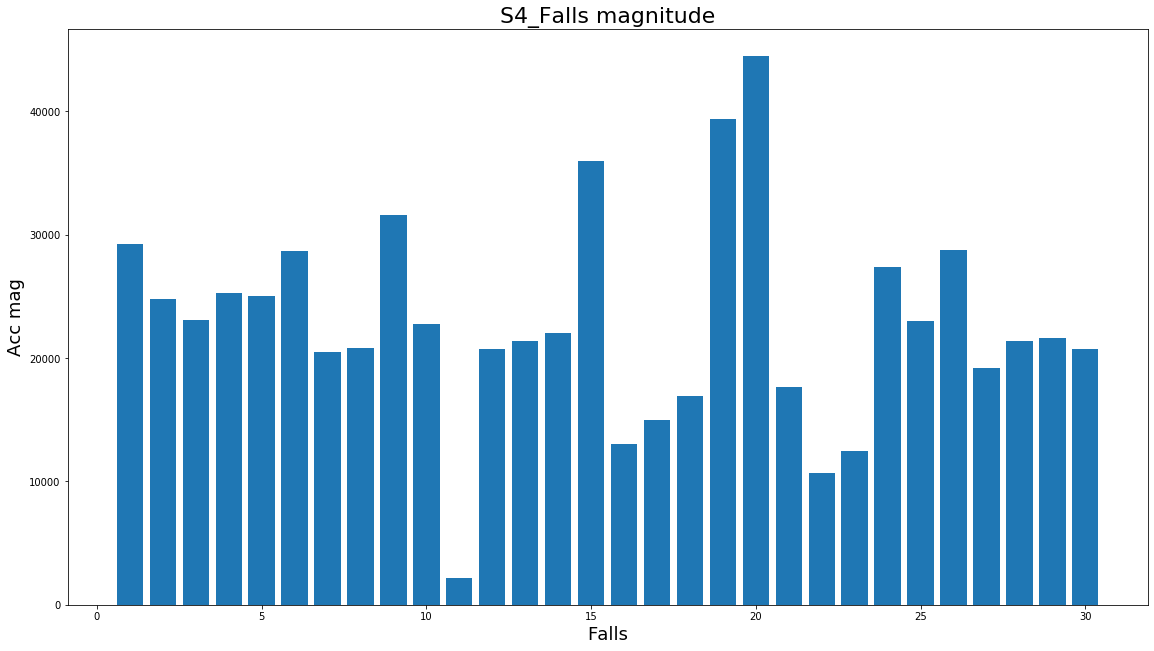

S5
Files present in  S5  folder
S5-Airbag.CSV   (1419261, 22)
shape of total  S5  file (1419261, 22)
shape of falls combined  (30, 5)


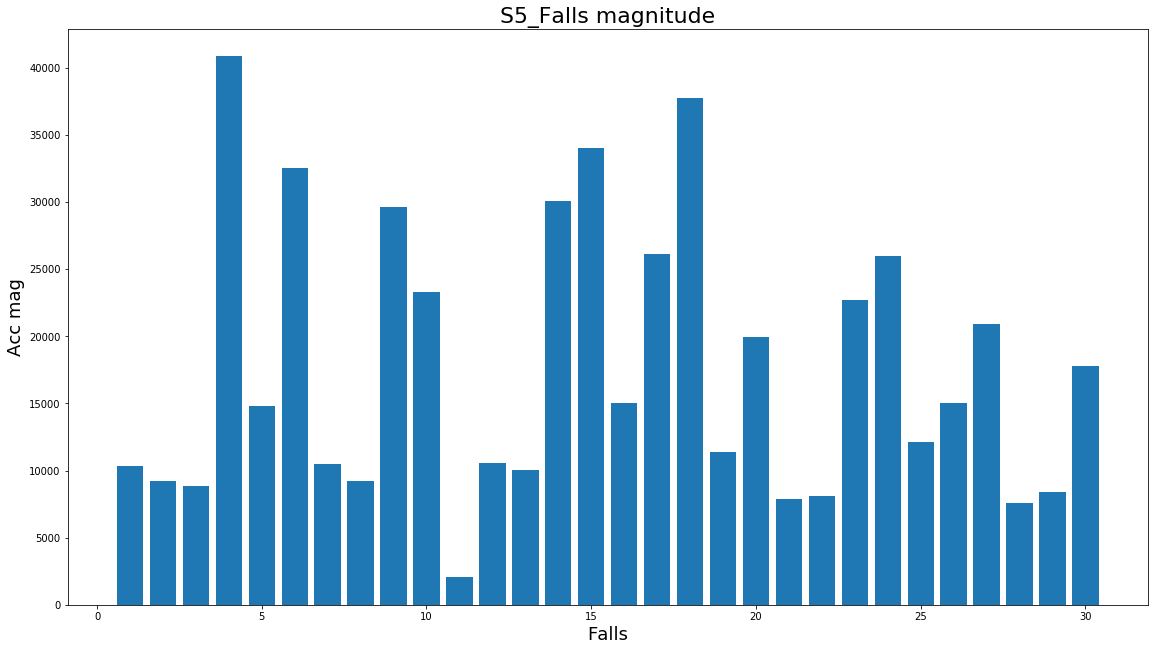

S6
Files present in  S6  folder
S6-Airbag.CSV   (1048576, 22)
shape of total  S6  file (1048576, 22)
shape of falls combined  (26, 5)


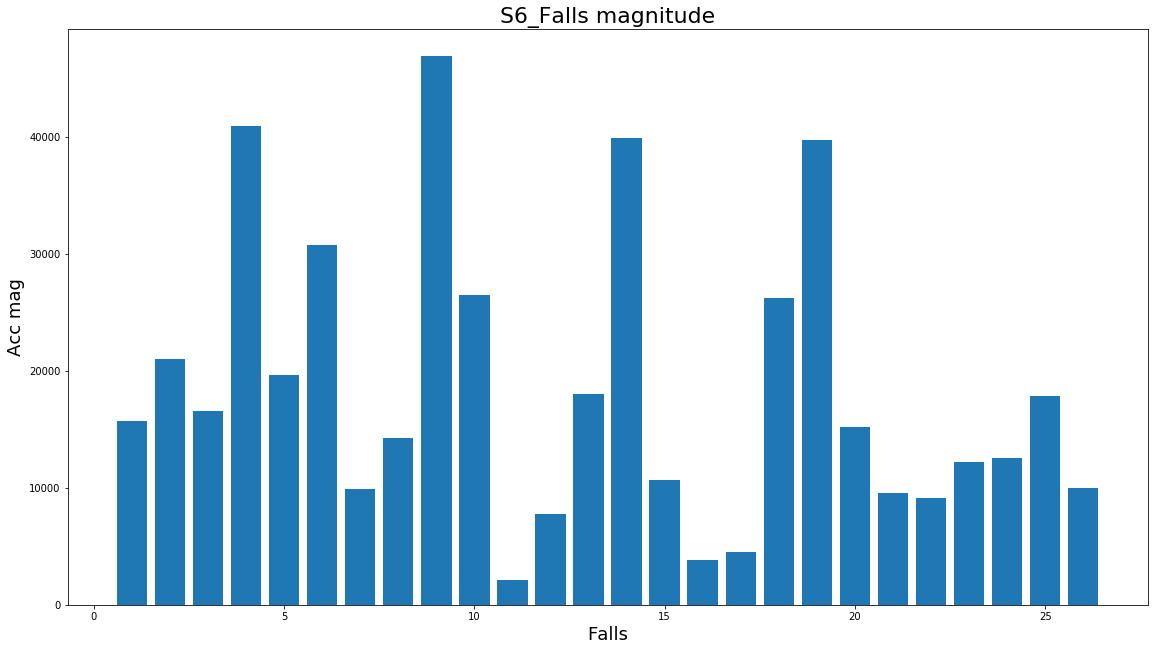

S7
Files present in  S7  folder
S7-Airbag.CSV   (1748850, 22)
shape of total  S7  file (1748850, 22)
shape of falls combined  (33, 5)


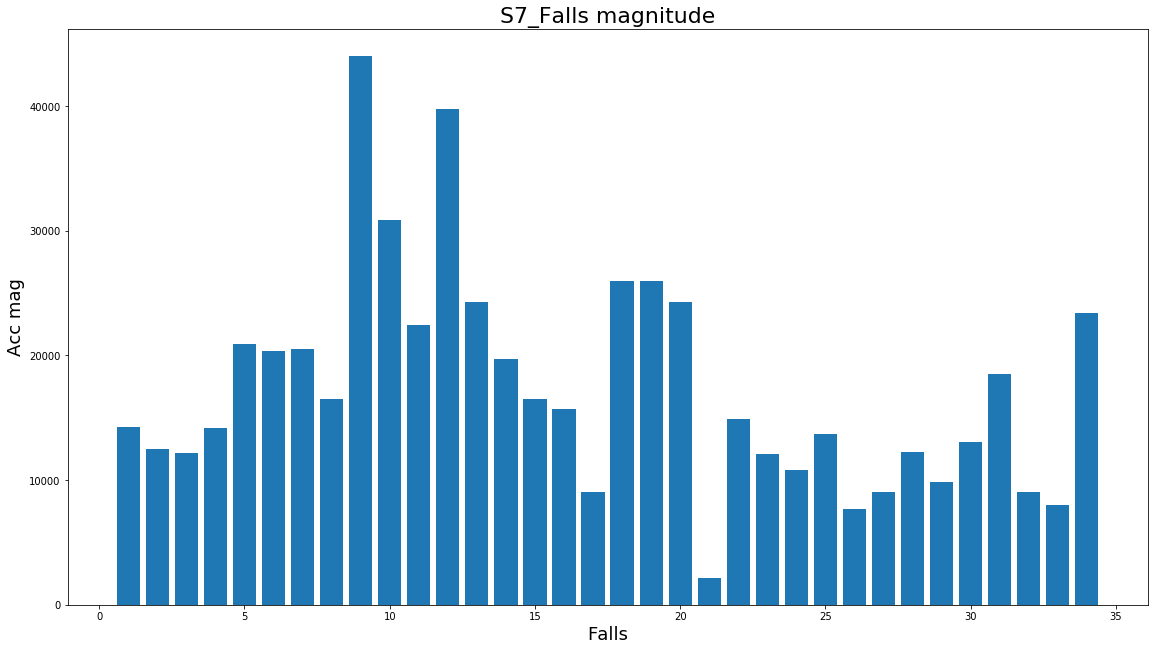

S8
Files present in  S8  folder
L0000001.CSV   (2054, 22)
L0000002.CSV   (70650, 22)
L0000003.CSV   (164571, 22)
L0000004.CSV   (1316063, 22)
S8-Airbag.CSV   (1048575, 22)
shape of total  S8  file (2601913, 22)
shape of falls combined  (30, 5)


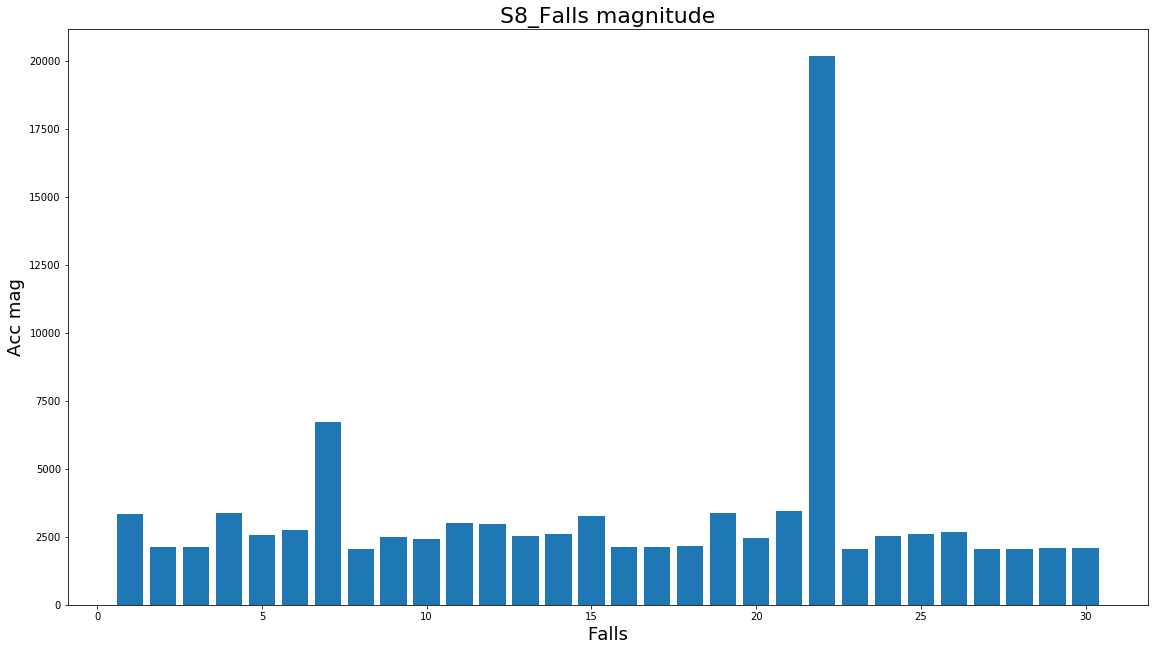

S9
Files present in  S9  folder
L0000003.CSV   (62508, 22)
L0000004.CSV   (56353, 22)
L0000005.CSV   (316771, 22)
L0000006.CSV   (49576, 22)
L0000007.CSV   (3977, 22)
L0000009.CSV   (250569, 22)
L0000010.CSV   (358523, 22)
shape of total  S9  file (1098277, 22)
shape of falls combined  (13, 5)


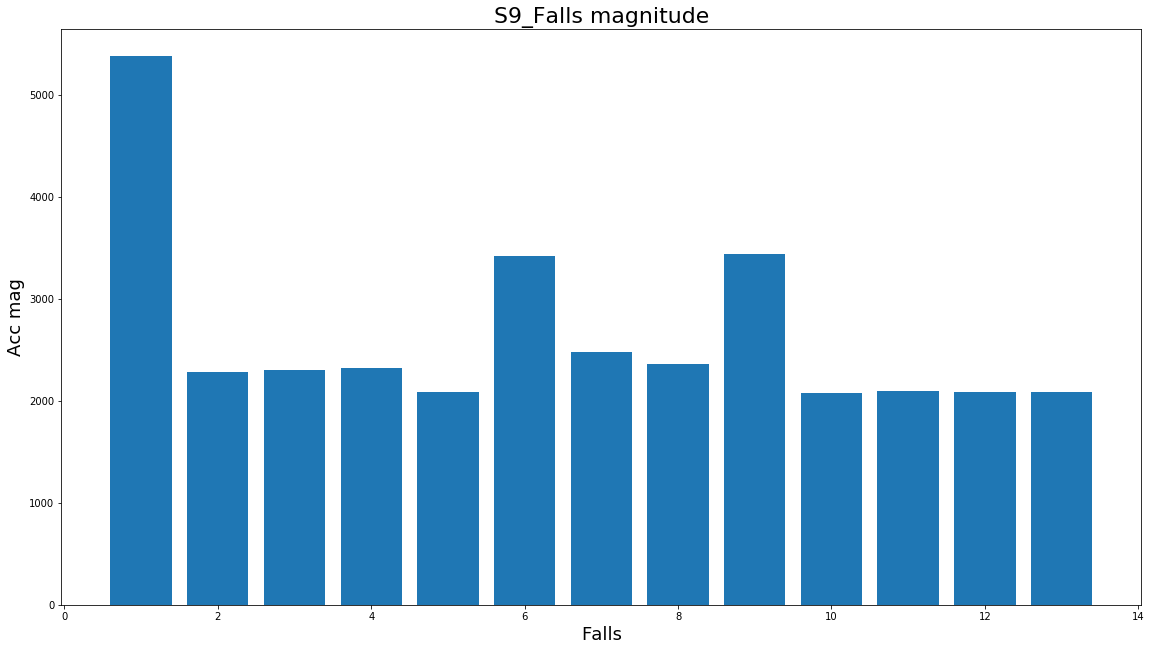

S10
Files present in  S10  folder
L0000002.CSV   (2911, 22)
L0000003.CSV   (22505, 22)
L0000004.CSV   (242895, 22)
L0000005.CSV   (320727, 22)
L0000006.CSV   (596899, 22)
L0000007.CSV   (519961, 22)
shape of total  S10  file (1705898, 22)
shape of falls combined  (25, 5)


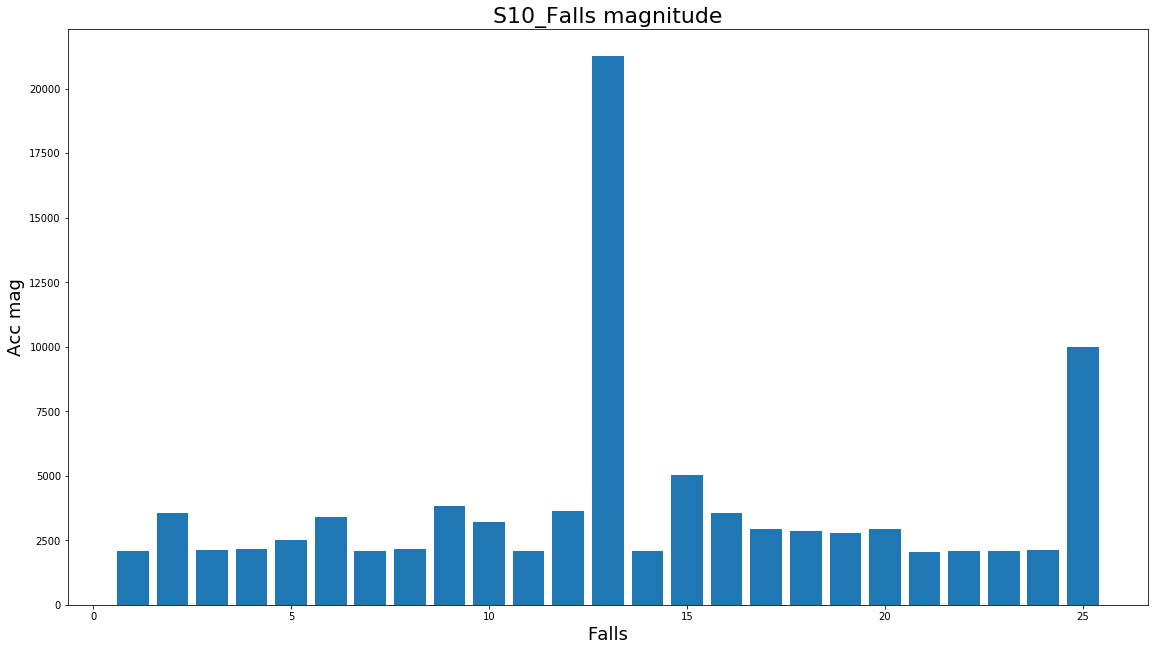

S11
Files present in  S11  folder
L0000002.CSV   (102481, 22)
L0000003.CSV   (473900, 22)
L0000004.CSV   (507278, 22)
L0000005.CSV   (972701, 22)
shape of total  S11  file (2056360, 22)
shape of falls combined  (26, 5)


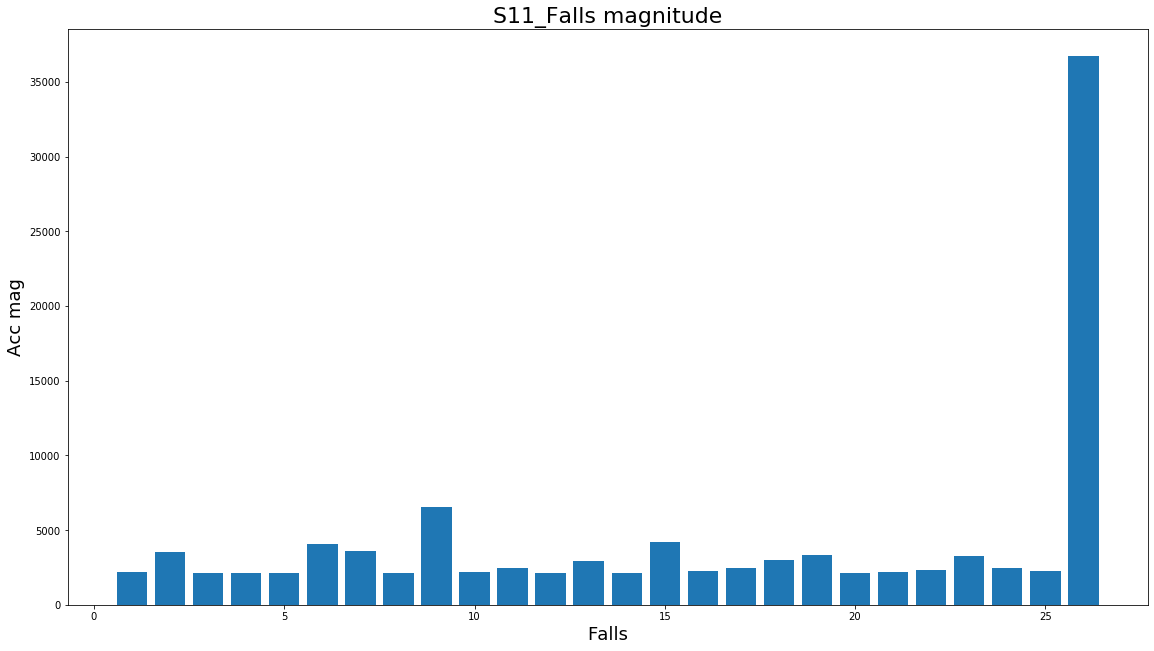

S12
Files present in  S12  folder
L0000002.CSV   (14137, 22)
L0000003.CSV   (658840, 22)
L0000004.CSV   (576269, 22)
shape of total  S12  file (1249246, 22)
shape of falls combined  (16, 5)


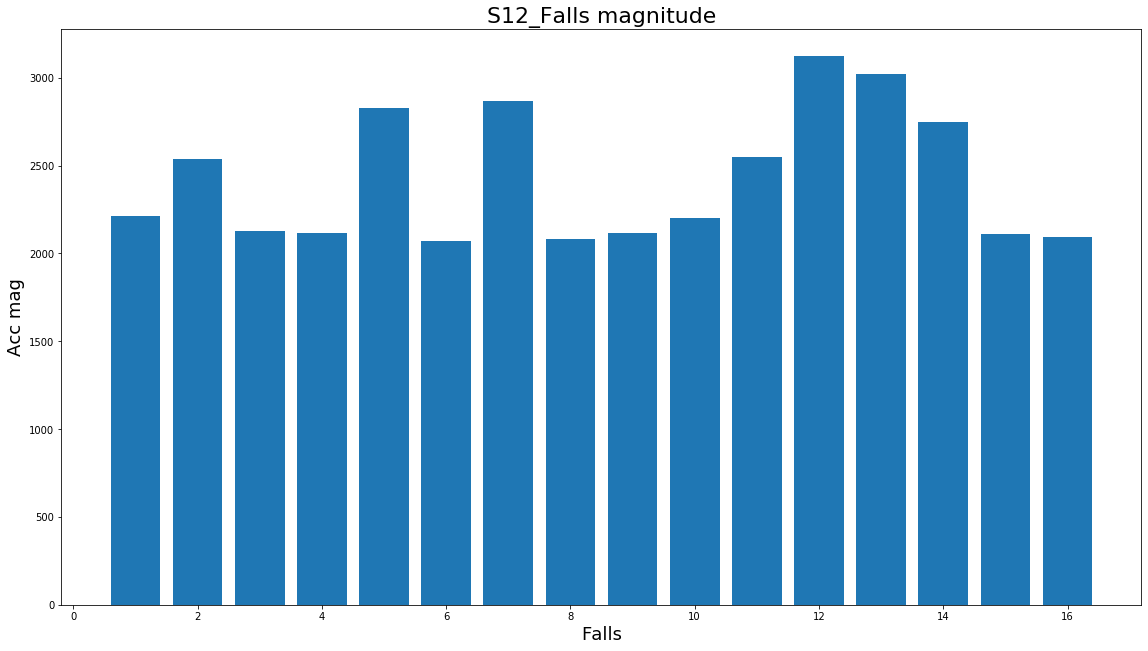

S13
Files present in  S13  folder
L0000021.CSV   (892472, 22)
L0000022.CSV   (397477, 22)
shape of total  S13  file (1289949, 22)
shape of falls combined  (17, 5)


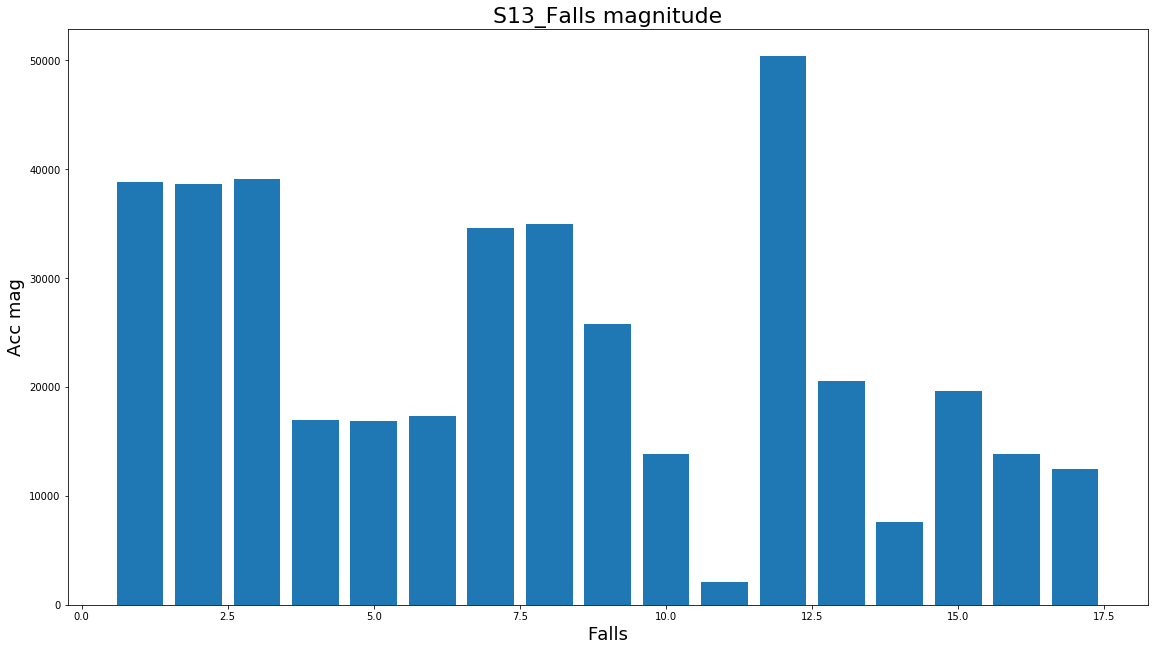

S14
Files present in  S14  folder
L0000003.CSV   (2060337, 22)
shape of total  S14  file (2060337, 22)
shape of falls combined  (33, 5)


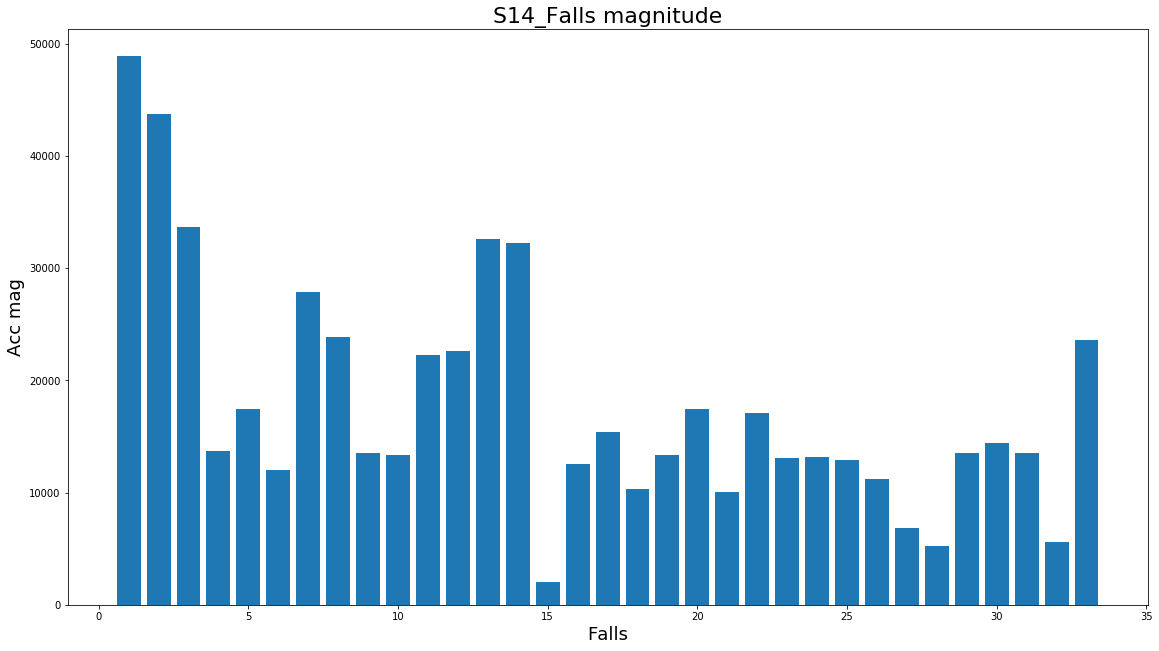

S15
Files present in  S15  folder
L0000002.CSV   (870575, 22)
L0000003.CSV   (682519, 22)
shape of total  S15  file (1553094, 22)
shape of falls combined  (24, 5)


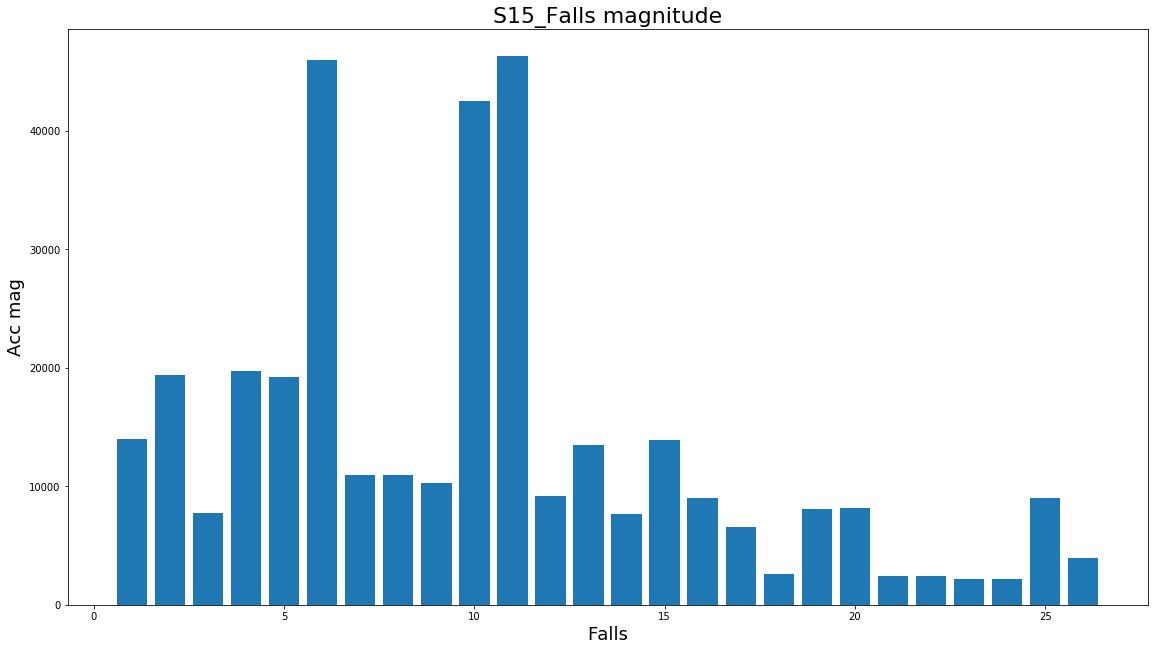

S16
Files present in  S16  folder
L0000002.CSV   (1907513, 22)
shape of total  S16  file (1907513, 22)
shape of falls combined  (35, 5)


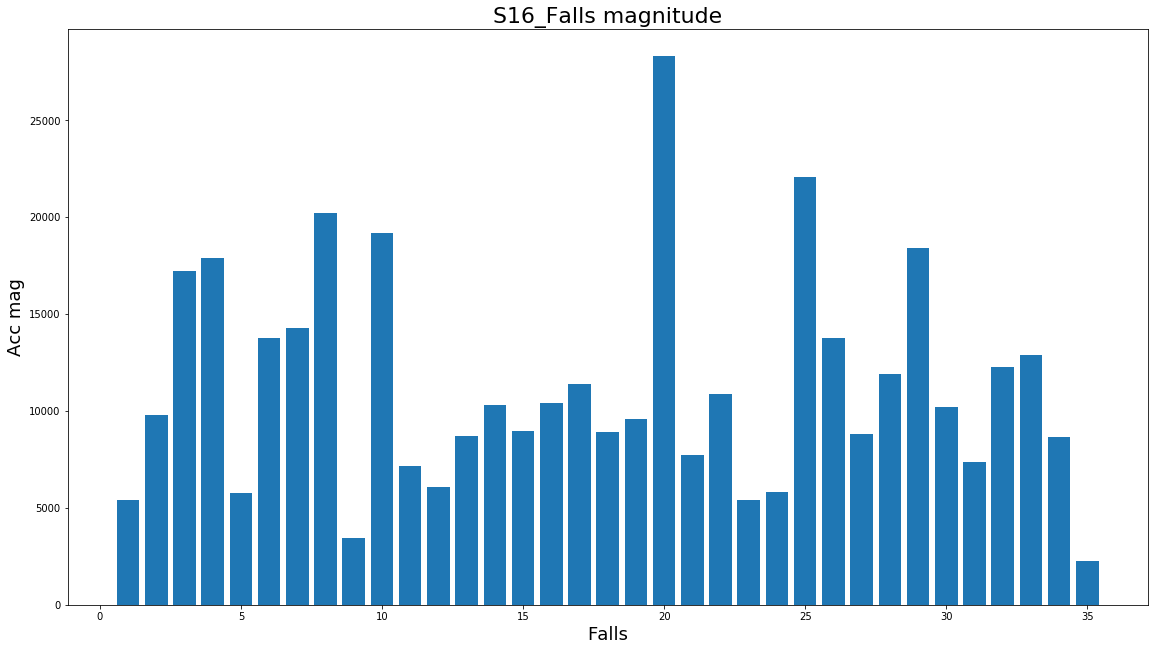

S17
Files present in  S17  folder
L0000002.CSV   (252338, 22)
L0000003.CSV   (731896, 22)
L0000004.CSV   (202133, 22)
shape of total  S17  file (1186367, 22)
shape of falls combined  (16, 5)


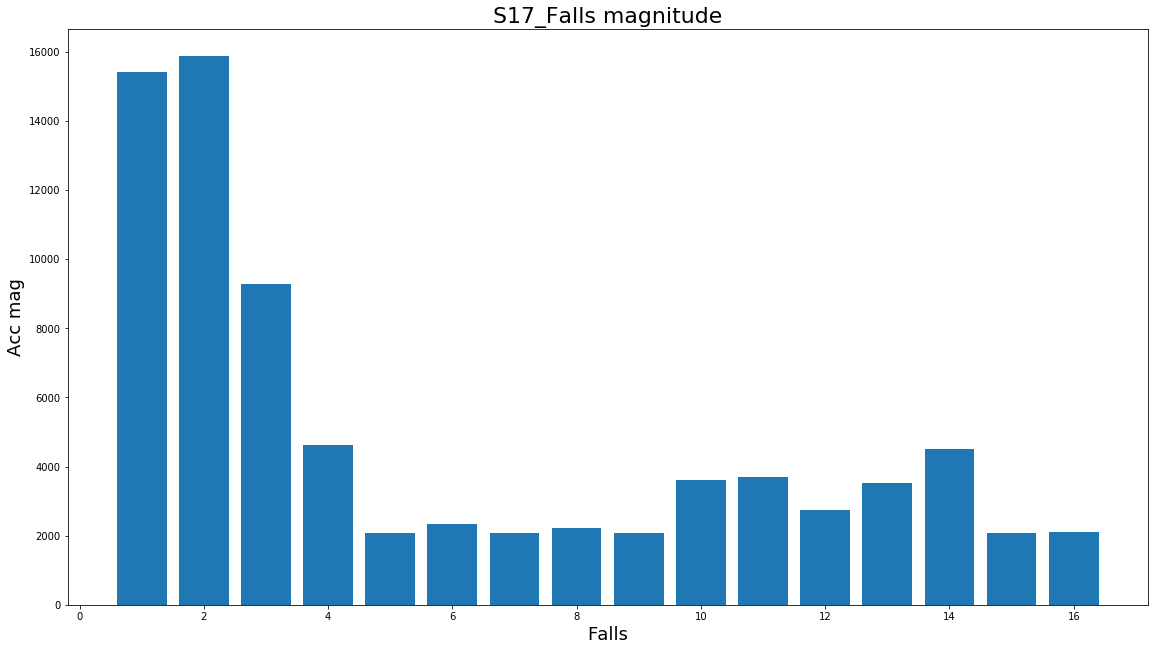

S19
Files present in  S19  folder
L0000002.CSV   (63893, 22)
L0000003.CSV   (1140799, 22)
shape of total  S19  file (1204692, 22)
shape of falls combined  (21, 5)


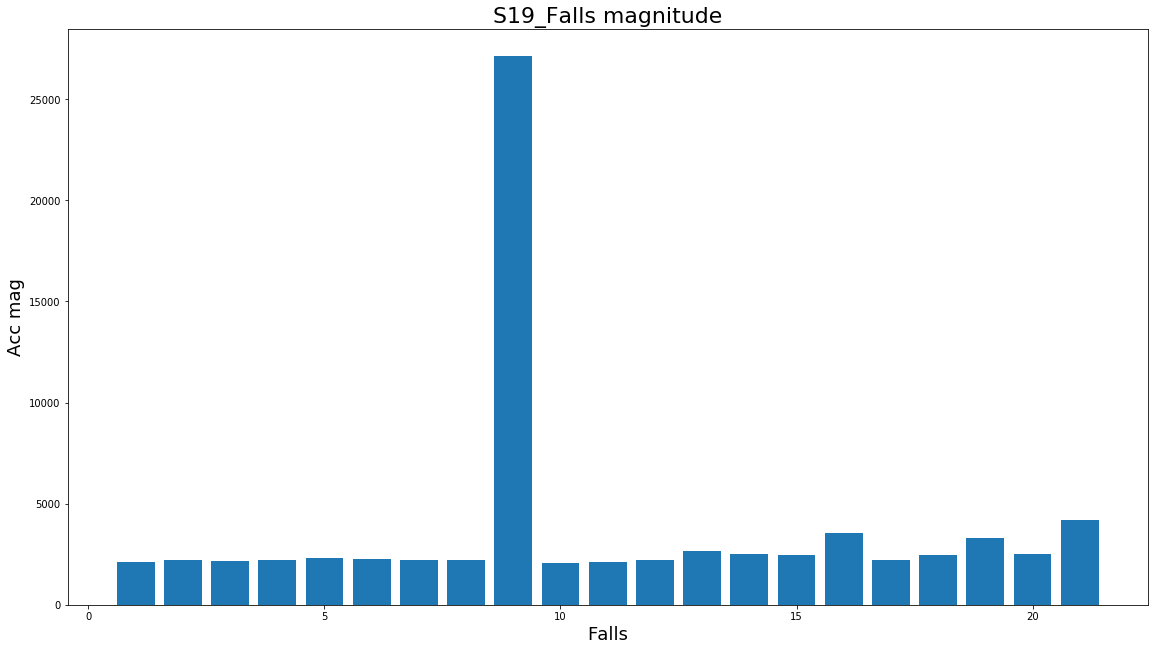

S20
Files present in  S20  folder
L0000002.CSV   (42111, 22)
L0000003.CSV   (897, 22)
L0000004.CSV   (1584, 22)
L0000005.CSV   (1582121, 22)
shape of total  S20  file (1626713, 22)
shape of falls combined  (28, 5)


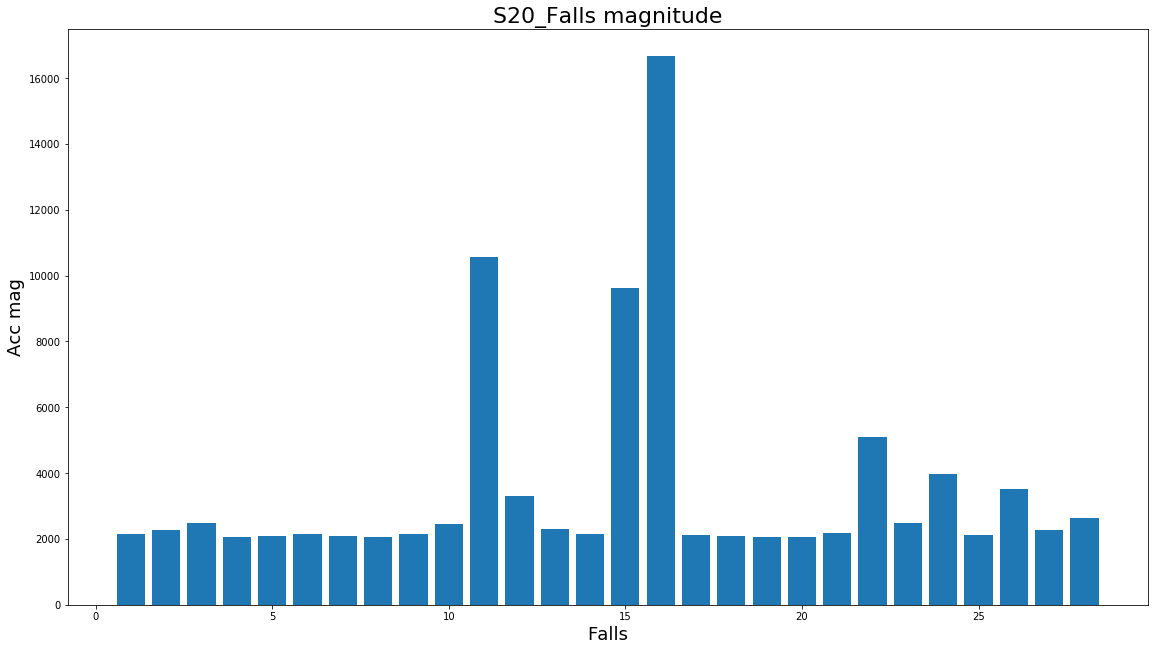

S21
Files present in  S21  folder
L0000002.CSV   (120036, 22)
L0000003.CSV   (51509, 22)
L0000004.CSV   (19276, 22)
L0000005.CSV   (2575, 22)
L0000006.CSV   (23283, 22)
L0000007.CSV   (733, 22)
L0000008.CSV   (52332, 22)
L0000009.CSV   (2858, 22)
L0000010.CSV   (51719, 22)
L0000011.CSV   (84595, 22)
L0000012.CSV   (5968, 22)
L0000013.CSV   (281309, 22)
L0000014.CSV   (944, 22)
L0000015.CSV   (263046, 22)
shape of total  S21  file (960183, 22)
shape of falls combined  (20, 5)


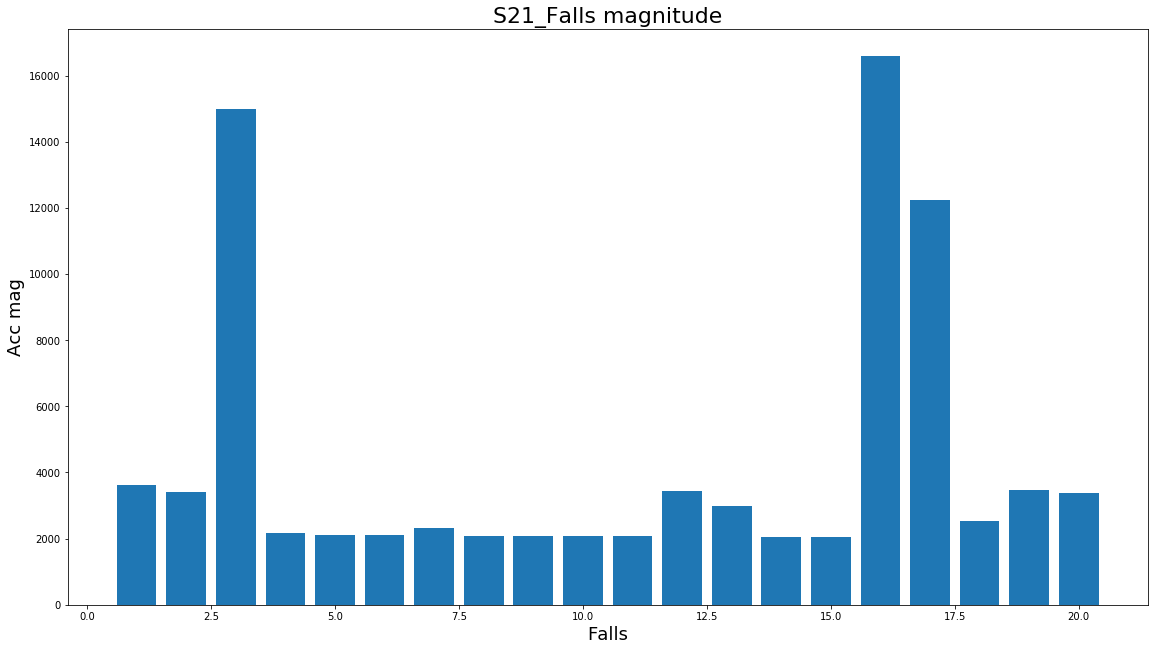

S22
Files present in  S22  folder
L0000002.CSV   (258619, 22)
L0000003.CSV   (1242, 22)
L0000004.CSV   (134260, 22)
L0000005.CSV   (218062, 22)
L0000006.CSV   (112852, 22)
L0000007.CSV   (720, 22)
L0000008.CSV   (739, 22)
L0000009.CSV   (5232, 22)
L0000010.CSV   (1706, 22)
L0000011.CSV   (420720, 22)
L0000012.CSV   (564, 22)
L0000013.CSV   (853, 22)
L0000014.CSV   (12309, 22)
L0000015.CSV   (87575, 22)
L0000016.CSV   (143322, 22)
shape of total  S22  file (1398775, 22)
shape of falls combined  (16, 5)


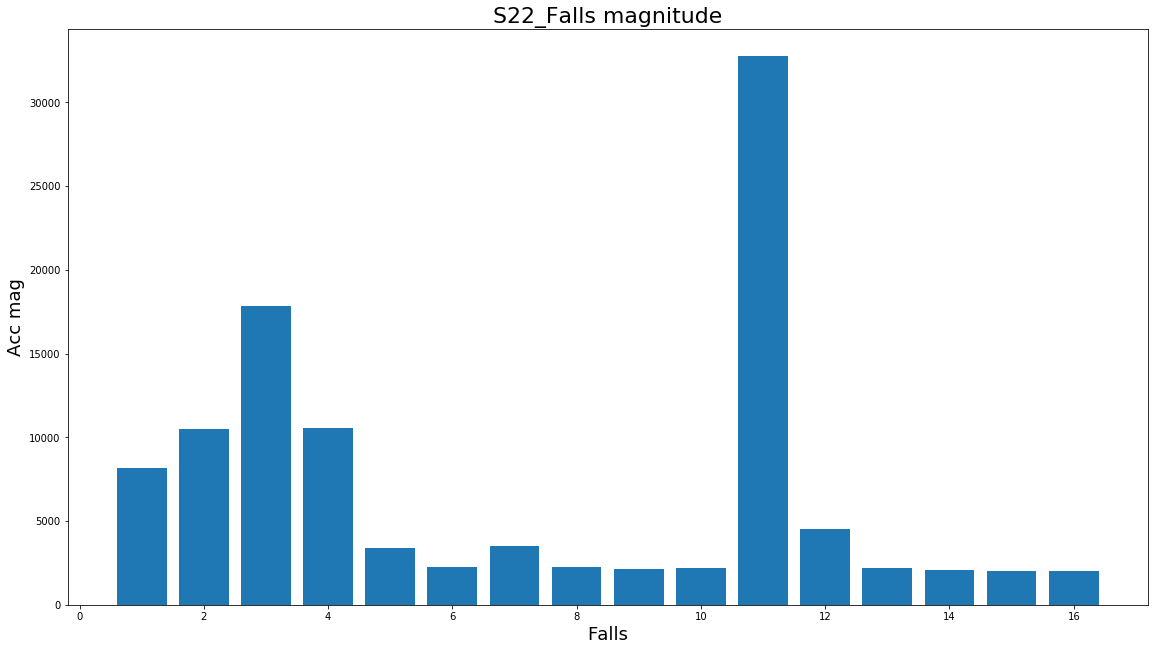

S23
Files present in  S23  folder
L0000002.CSV   (47224, 22)
L0000003.CSV   (16656, 22)
L0000004.CSV   (14569, 22)
L0000005.CSV   (5512, 22)
L0000006.CSV   (3359, 22)
L0000007.CSV   (166, 22)
L0000008.CSV   (8194, 22)
L0000009.CSV   (309, 22)
L0000010.CSV   (8066, 22)
L0000011.CSV   (51282, 22)
L0000012.CSV   (160, 22)
L0000013.CSV   (6529, 22)
L0000014.CSV   (125460, 22)
L0000015.CSV   (577933, 22)
L0000016.CSV   (214858, 22)
L0000017.CSV   (2367, 22)
L0000018.CSV   (4244, 22)
L0000019.CSV   (227, 22)
L0000020.CSV   (55228, 22)
L0000021.CSV   (46393, 22)
L0000022.CSV   (275786, 22)
L0000023.CSV   (196, 22)
L0000024.CSV   (15, 22)
L0000025.CSV   (74316, 22)
L0000026.CSV   (4835, 22)
L0000028.CSV   (371, 22)
L0000029.CSV   (12833, 22)
L0000030.CSV   (77856, 22)
shape of total  S23  file (1634944, 22)
shape of falls combined  (29, 5)


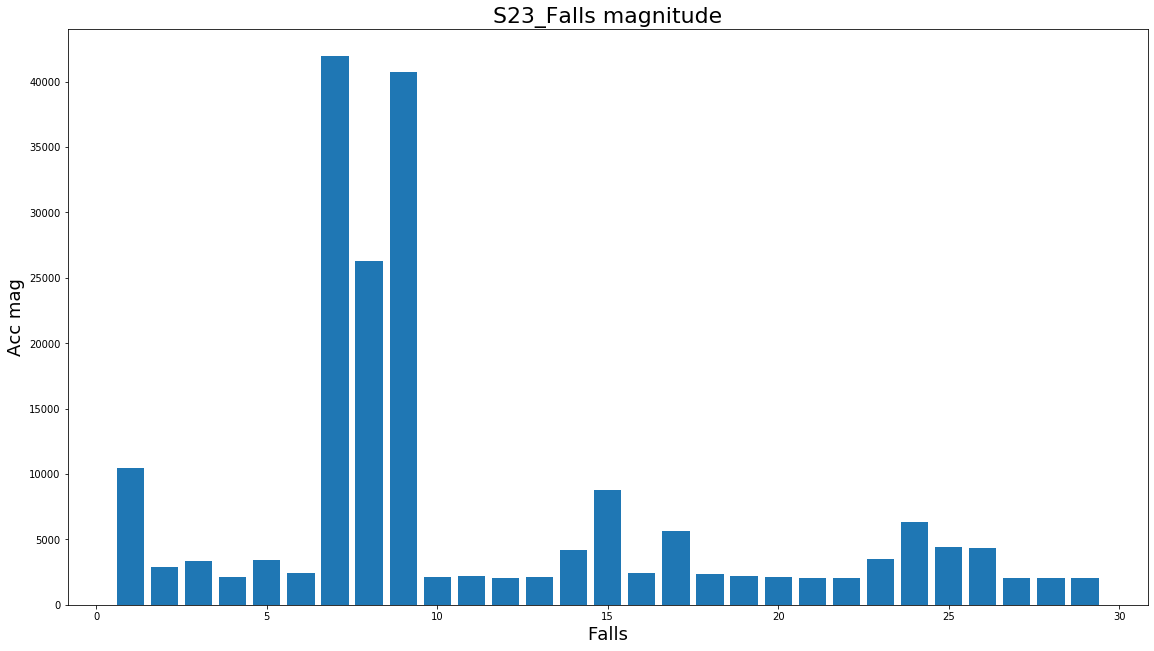

S25
Files present in  S25  folder
L0000002.CSV   (500141, 22)
L0000003.CSV   (382343, 22)
L0000004.CSV   (252125, 22)
shape of total  S25  file (1134609, 22)
shape of falls combined  (32, 5)


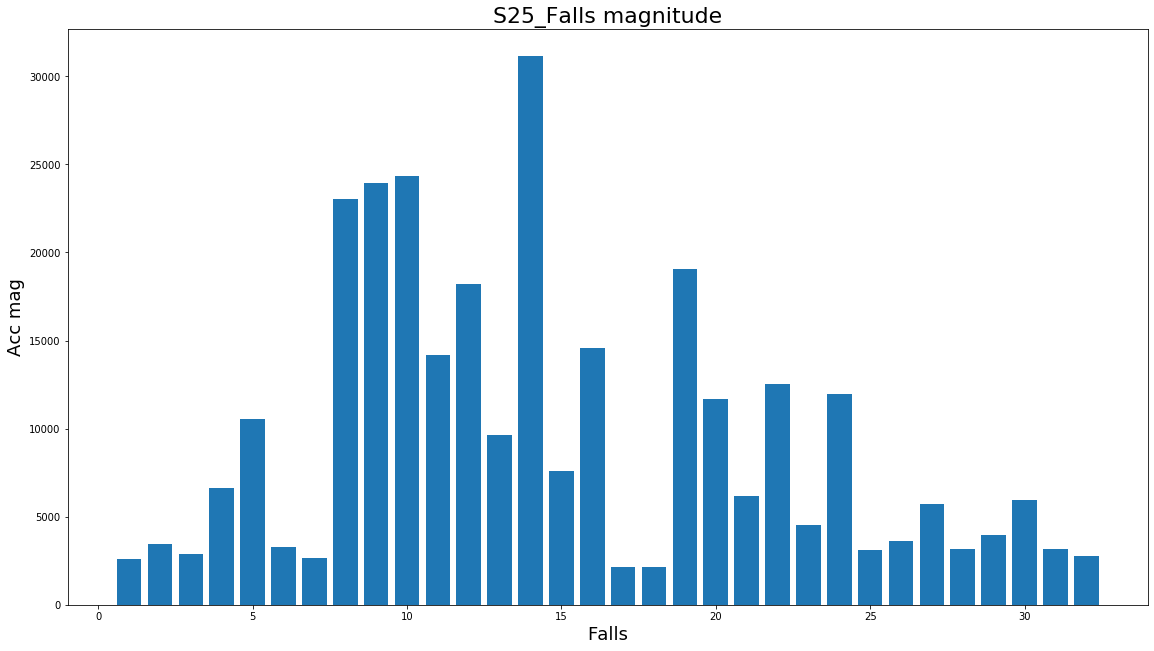

In [286]:
subjects = ['S4','S5','S6','S7','S8','S9','S10','S11','S12','S13','S14','S15','S16','S17','S19','S20','S21','S22','S23','S25']
for subject in subjects:
    print(subject)
    generate_all_falls(subject)

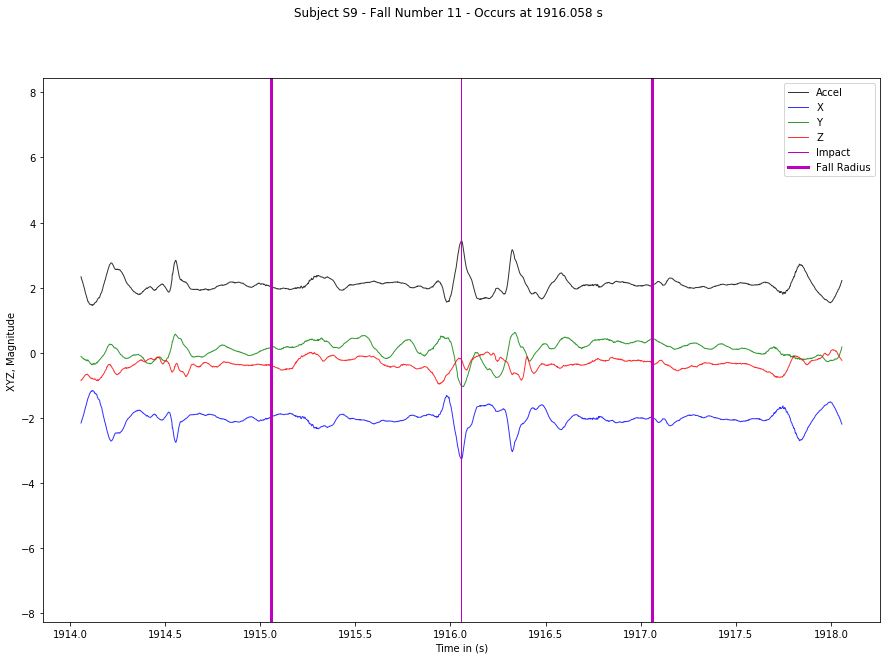

In [132]:
falls = len(concatenate_csv.loc[concatenate_csv["cal_impact_milisec"] == 80])
fn = 10
f = plot_falls_zoomed(concatenate_csv, 2000, 2000, subject, fn, width=15, height=10)